# Classification of User Knowledge Based on the Degree of Study Time for Goal Object Materials and the Degree of Repetition Number of User for Goal Object Materials
by Kyrstin Lavelle, Yushin Nam, Accita Ongko, Krianna Strowbridge

![](data/study_img.jpeg)
*Source: https://acmaps.info.yorku.ca/2014/12/studying-for-your-exams/*


## Introduction
Comprehending the ways in which students engage in learning and gain knowledge is crucial. This can help educational professionals understand effective learning strategies and help prepare students better. Tests are a commonly used measure to assess students' knowledge. Bartoszewski et al showed that different learning techniques such as practice retrieval are correlated with better test results (Bartoszewski & Gurung, 2015). However, standardised tests do not give an accurate replication of a student's knowledge (Schneider, 2017).

The current study will use statistical methods to explore a classification model that uses degree of study time (STG) and degree of repetition(SCG)  to predict knowledge levels (UNS).The current study aims to understand what student’s knowledge levels (UNS).  Research indicates that both the duration of study and the repetition of material have been verified to enhance knowledge, and are frequently used study techniques (Dunlosky et al., 2013).  A classification model will be used as the knowledge level is a non-numeric, categorical variable. A classification model was chosen over a regression model because our aim is to classify students' knowledge into classes of very low, low, medium and high; not a numeric value. A successful K-nearest neighbour (KNN ) model can identify students at risk of low or very low knowledge levels early in their learning process, which allows for early risk mitigation and intervention, such as providing additional support and learning materials.

The *User Knowledge* database will be used, including 403 observations. This dataset is multivariate including 5 predator variants and 1 target variable. The database was developed in 2013 and shows student’s knowledge about electrical DC machines, which are electromechanical energy alteration devices (Agarwal, 2020). This database will be used to answer the following research question:

* **What are the student's knowledge levels based on STG (the degree of study time for goal object materials) and SCG (the degree of repetition number of user for goal object materials)?**

## Methods

The $K$-nearest neighbor classification model will be used, with **STG** and **SCG** columns as the two predictors and the UNS column as the response variable. Since the data is split already into a training set and a test set, it is not necessary to split it again.

* The first step is to choose the most suitable parameter K by splitting the training data into multiple different train/validation splits through cross-validation. A 10-fold cross-validation will be used to create 10 different validation sets.
* The K-value that gives the best accuracy will be chosen with the help of tuned models and a plot that shows accuracy versus K.
* The chosen K-value will be incorporated into the KNN model, along with the standardised recipe and model specification, to make predictions on the testing set.
* Prediction results will be visualised through a scatter plot with “Study Time (STG)” on the x-axis and “Degree of Repetition (SCG)” on the y-axis. Each point will represent the predicted classification of the user knowledge, labeled different colors for different knowledge levels (i.e. very low, low, middle, and high).
* The accuracy of the KNN classification model will be evaluated using the metrics function and the confusion matrix. 

In [1]:
library(tidyverse)
library(readxl)
library(tidymodels)
library(dplyr)

set.seed(1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

The following cells show loading the excel file from the web, as well as selecting the variable of interest and changing the names of variables so that it is convenient to see:
   * **STG** = study_time
   * **SCG** = repetition
   * **UNS** = knowledge_level
   
By using "as_factor", knowledge_level is converted into a factor type. Additionally, "very_low" class in knowledge_level is renamed as "Very Low". 

In [2]:
url <- "https://github.com/lojnys/dsci100_group_18/raw/main/data/knowledge1.xls"
destfile <- "data/knowledge1.xls"
download.file(url, destfile)

In [3]:
data_training = read_excel(destfile, sheet = "Training_Data", range="A1:F259")
head(data_training)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


*Figure 0.1: Training dataset*

In [4]:
data_wrangled <- data_training |>
select(STG, SCG, UNS) |>
rename(study_time = STG, repetition = SCG, knowledge_level = UNS) |>
mutate(knowledge_level = as_factor(knowledge_level)) # knowledge_level is the response variable
# mutate(knowledge_level = fct_recode(knowledge_level, "Very Low" = "very_low")) # rename "very_low" to "Very Low"

unique_levels <- unique(data_wrangled$knowledge_level)
unique_levels

data_wrangled$knowledge_level <- fct_relevel(
  data_wrangled$knowledge_level,
  "Very Low", "Low", "High", "Middle"
)

levels(data_wrangled$knowledge_level)

head(data_wrangled)

[1] Very Low High     Low      Middle  
Levels: Very Low High Low Middle

[1] "Very Low" "Low"      "High"     "Middle"

study_time,repetition,knowledge_level
<dbl>,<dbl>,<fct>
0.00,0.00,Very Low
0.08,0.08,High
0.06,0.06,Low
0.10,0.10,Middle
0.08,0.08,Low
0.09,0.15,Middle


*Figure 0.2: Training dataset wrangled*

The two cells below display each mean/average values of study time and repetition, and the number of each category in knowledge level of users, respectively. 

In [5]:
data_wrangled |>
select(study_time, repetition) |>
map(mean, na.rm  = TRUE)

$study_time
[1] 0.3711473

$repetition
[1] 0.3556744

*Figure 0.3: Mean of Predictors*

In [6]:
data_wrangled |>
group_by(knowledge_level) |>
summarize(count = n()) |>
pivot_wider(names_from = knowledge_level, values_from = count)

Very Low,Low,High,Middle
<int>,<int>,<int>,<int>
24,83,63,88


*Figure 0.4: Total number of observations per category of User Knowledge*

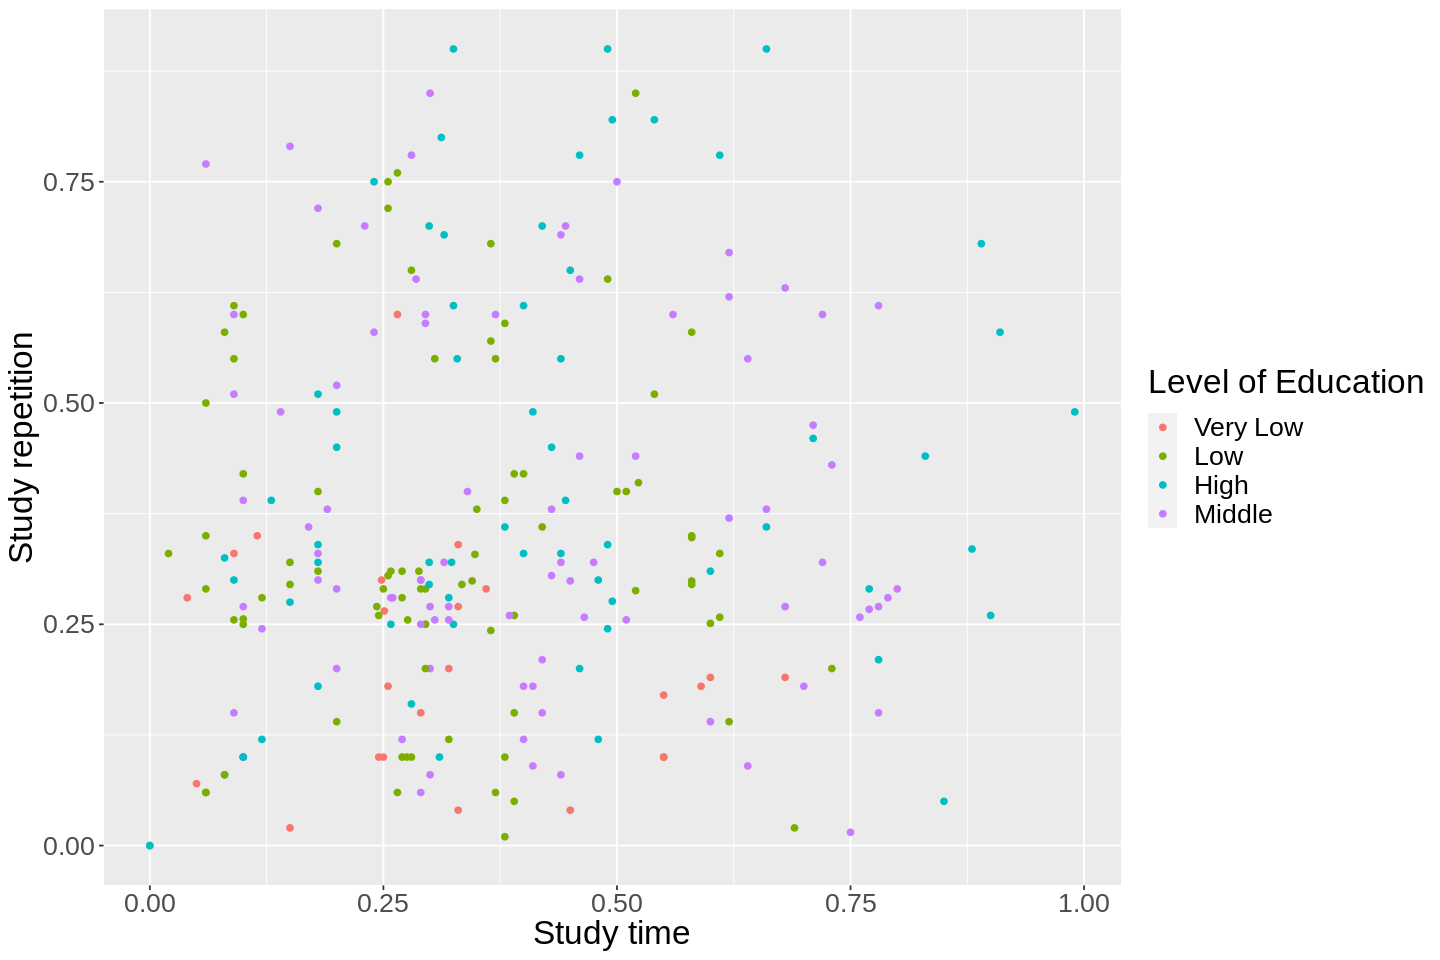

In [7]:
options(repr.plot.width = 12, repr.plot.height = 8)
stg_vs_scg_plot <- data_wrangled |>
ggplot(aes(x = study_time, y = repetition, color = knowledge_level)) +
geom_point() +
labs(x = "Study time", y = "Study repetition", color = "Level of Education") +
theme(text = element_text(size = 20))

stg_vs_scg_plot

*Figure 1: Study time vs. Study repeition plot*

## KNN Classification

The following cell shows the process of reading the testing dataset from the Excel file and renaming the variables to make them synonymous with the training dataset. 

In [8]:
# Testing dataset
data_testing <- read_excel(destfile, sheet = "Test_Data", range = "A1:F146") |>
select(STG, SCG, UNS) |>
rename(study_time = STG, repetition = SCG, knowledge_level = UNS) |>
mutate(knowledge_level = as_factor(knowledge_level))
head(data_testing)

study_time,repetition,knowledge_level
<dbl>,<dbl>,<fct>
0.00,0.10,Very Low
0.05,0.05,Low
0.08,0.18,High
0.20,0.20,High
0.22,0.22,High
0.14,0.14,Low


*Figure 2: Testing dataset*

In the following cell, we have created a k_val data frame with the neighbors variable containing values from 1 to 100 using the seq function.

A recipe and model specification for the classification model are also created. To specify that the parameter in the model ($K$) should be tuned, the argument "neighbors = tune()" is added into the nearest_neighbor function. A10-fold-cross-validation is then carried out on the wrangled training data to calculate an accuracy for each value of K. 

The recipe and model specification are then combined into a workflow, and the classifier is built using the fit function. The k_val data frame will be passed into the grid argument of the tune_grid function to fit the model for each value of K in the specified range of parameter values (1 to 100). 

A plot of accuracy versus $K$ is then created to visualise the relationship between each value of K in the specified range with their accuracy, as shown in Figure 3. 

→ A | warning: No observations were detected in `truth` for level(s): 'Very Low'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x2

There were issues with some computations   A: x2





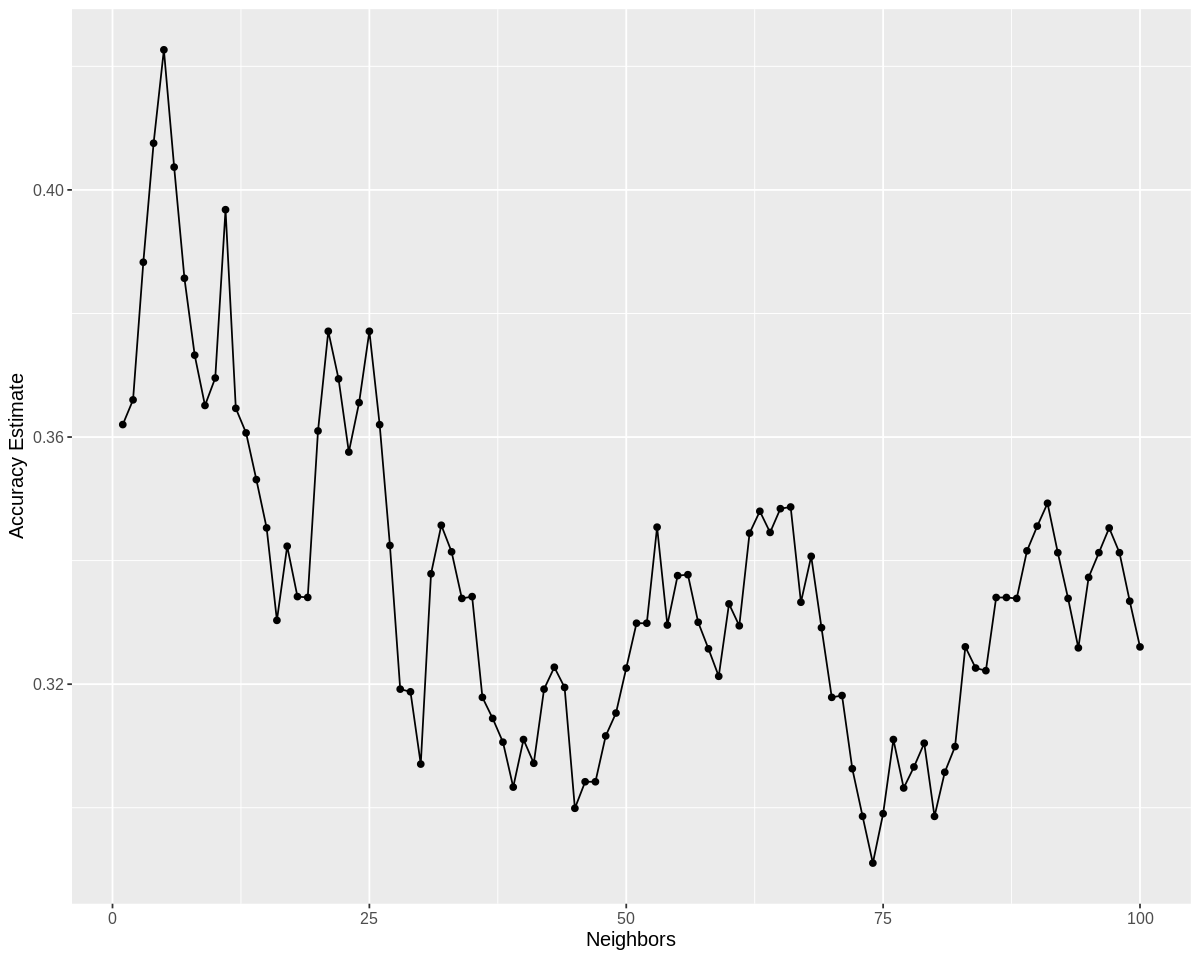

In [9]:
k_val <- tibble(neighbors = seq(from=1, to=100))

study_recipe <- recipe(knowledge_level ~ study_time + repetition, data = data_wrangled) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

study_vfold_10 <- vfold_cv(data_wrangled, v=10, strata=knowledge_level)

knn_results <- workflow() |>
add_recipe(study_recipe) |>
add_model(knn_spec) |>
tune_grid(resamples=study_vfold_10, grid=k_val) |>
collect_metrics()

accuracies <- knn_results |>
filter(.metric=="accuracy")

options(repr.plot.width=10, repr.plot.height=8)

accuracy_vs_k_plot <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
geom_point() +
geom_line() +
labs(x="Neighbors", y="Accuracy Estimate")+
theme(text=element_text(size=12))


accuracy_vs_k_plot

*Figure 3: Plot of estimated accuracy versus the number of neighbors*

Based on the plot shown in Figure 3, the most suitable K-value is *K = 5*. This K value was chosen to reflect optimal accuracy and stability since it has the highest accuracy that does not fluctuate as much when the K-value is increased or decreased.

In [10]:
highest_k <- accuracies |>
filter(mean == max(mean)) |>
pull(neighbors)

highest_k

[1] 5

The cell above shows that the $K$-value with the highest accuracy is indeed 5, which confirms the previous argument that $K=5$ should be chosen. 

In [11]:
knn_spec_5 <- nearest_neighbor(weight_func = "rectangular", neighbors = highest_k) |>
set_engine("kknn") |>
set_mode("classification")

knn_workflow <- workflow() |>
add_recipe(study_recipe) |>
add_model(knn_spec_5) |>
fit(data=data_wrangled)

pred <- knn_workflow |>
predict(data_testing) |>
bind_cols(data_testing)

head(pred)

.pred_class,study_time,repetition,knowledge_level
<fct>,<dbl>,<dbl>,<fct>
Low,0.00,0.10,Very Low
Low,0.05,0.05,Low
Low,0.08,0.18,High
Low,0.20,0.20,High
Very Low,0.22,0.22,High
High,0.14,0.14,Low


*Figure 4: The first 6 predictions on the testing data using K=5*

The cell above demonstrates the process of using $K$=5 into the classification model to predict the knowledge levels of the testing set. The first 6 rows of predictions can be seen in Figure 4. 

List of 1
 $ text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 15
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

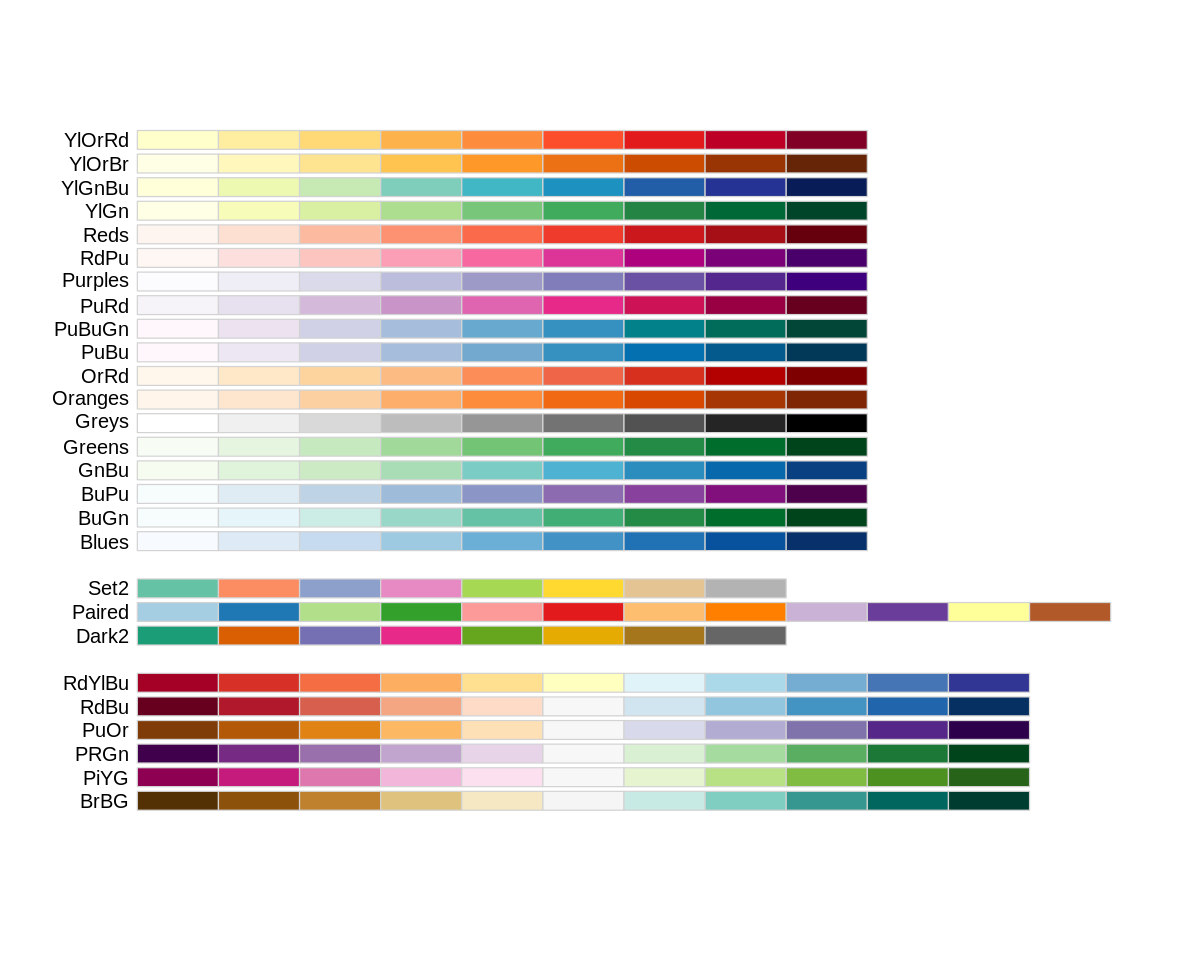

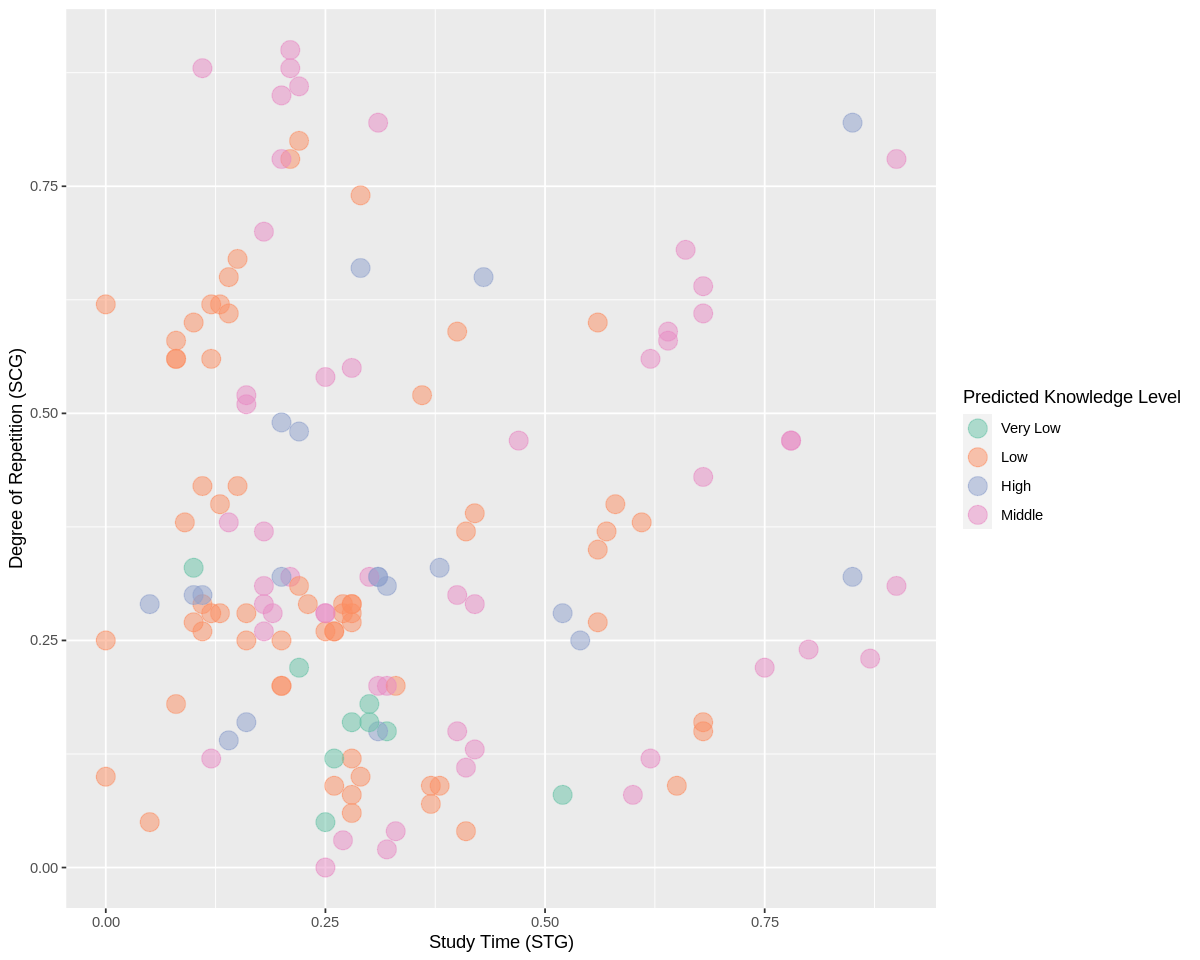

In [12]:
library(RColorBrewer)
display.brewer.all(colorblindFriendly = TRUE)

options(repr.plot.width=10, repr.plot.height=8)
prediction_plot <- pred |>
ggplot(aes(x=study_time, y=repetition, color=.pred_class))+
geom_point(alpha=0.5,size=5)+
labs(x="Study Time (STG)", y="Degree of Repetition (SCG)", color="Predicted Knowledge Level")+
scale_color_brewer(palette="Set2")
theme(text=element_text(size=15))

prediction_plot

*Figure 5: A scatter plot of degree of repetition against study time to visualise the predictions made on the testing set*

The cell above shows how to visualise the list of color-blind friendly color palettes that RColorBrewer has. The palette "Set2" will be used to label the predictions of the testing set on the scatter plot visualised in Figure 5. The code above also includes the process of visualising this scatter plot with study time on the x-axis and degree of repetition on the y-axis. 

## Evaluating Performance

The accuracy of the KNN classification model will be calculated in the cell below using the metrics function and the confusion matrix. The final accuracy of the model is proven to be approximately 0.338 (3 significant figures), which is 33.8% when expressed in percentage.

The precision and recall of very low and high predictions are also calculated in the cell below using "very low" and "high" as the positive predictions separately to compare between the two most contrasting categories of user knowledge levels.

In [21]:
pred_metrics <- pred |>
metrics(truth = knowledge_level, estimate = .pred_class)

pred_accuracy <- pred_metrics |>
filter(.metric == "accuracy") |>
select(.estimate) |>
pull()
print(paste("The accuracy of our model is", pred_accuracy))

pred_conf_mat <- pred |>
conf_mat(truth = knowledge_level, estimate = .pred_class)
pred_conf_mat

very_low_precision <- 3/(3+1+4+1)
print(paste("The precision of very low predictions is", very_low_precision))

very_low_recall <- 3/(3+26+8+11)
print(paste("The recall of very low predictions is", very_low_recall))

high_precision <- 8/(2+4+8+5)
print(paste("The precision of high predictions is", high_precision))

high_recall <- 8/(3+26+8+11)
print(paste("The recall of high predictions is", high_recall))

[1] "The accuracy of our model is 0.331034482758621"


          Truth
Prediction Very Low Low High Middle
  Very Low        3   1    4      1
  Low            15  26    8     17
  High            2   4    8      5
  Middle          6  15   19     11

[1] "The precision of very low predictions is 0.333333333333333"
[1] "The recall of very low predictions is 0.0625"
[1] "The precision of high predictions is 0.421052631578947"
[1] "The recall of high predictions is 0.166666666666667"


*Figure 6: A confusion matrix showing the total observations of all predictions made and the final accuracy, precision, and recall of the model*

## Discussion

  The method for determining students’ knowledge levels based on STG (the degree of study time for goal object materials) and SCG (the degree of repetition number of user for goal object materials) proposed in this paper has been shown to be a poor predictor of knowledge levels. 
 
  The K nearest neighbour algorithm, in which “the nearest neighbor is calculated according to k-value that determines the number of nearest neighbors to be considered and hence defining the class of a sample data point” (Abu Amra and Maghari, 2017), was employed to determine the relationship between selected variables. A K-value of 5 was selected to reflect optimal accuracy and stability since it has the highest accuracy that does not fluctuate as much when the K-value increases or decreases.
    
  The accuracy of our model is 0.3379, which is quite low, meaning the algorithm did a poor job of correctly classifying the testing data. Through the analysis and visualization of the data it was expected that the classifier would predict higher levels of knowledge for users with longer study time for goal object materials and higher degree of repetition number for goal object materials. This was not shown to be true. In this particular case, we’ve determined that the predictor variables selected are not strongly related enough to knowledge level to produce meaningful results.Were this same experiment to be modified and repeated, different predictor variables could possibly produce significant and relevant results. 
    
  More experiments investigating the relationship of knowledge level and different variables in the dataset could be beneficial in clarifying what factors influence a student’s knowledge level. A successful K-nearest neighbour model can be helpful to identify students at risk of low or very low knowledge levels early in the learning process, allowing for early risk mitigation and intervention, such as providing additional support and learning materials. Another possible modification, beyond the scope of this course, could be to use a different classification algorithm to analyse the strength of relationships between different sets of variables.
    
  K-nearest-neighbour is not a perfect algorithm and is prone to error under certain circumstances, including large numbers of predictors and when classes are imbalanced. In this specific case, there was a low accuracy level which made KNN classification less effective in answering our question. Much of the materials referenced when constructing this specific classification project had higher levels of accuracy and thus were able to more precisely confirm or deny their original hypothesis. In this particular case, it is difficult to analyse our findings because of low accuracy due to a poor choice of predictor variables. 


Questions for further investigation on this topic include:

* **What is the most optimal study time and degree of repetition for a high level of user knowledge?**
* **Are there individual differences in how study time and degree of repetition affect knowledge levels?**

Answers to these questions could provide students and professors alike with concrete guides for efficient learning and optimal performance.

## References

* Agarwal, T. (2020, October 31). DC machine - construction, working, types, EMF Equation & Applications. ElProCus. https://www.elprocus.com/dc-machine-types-and-their-applications/#:~:text=A%20DC%20machine%20is%20an,that%20rotates%20the%20dc%20motor
* Bartoszewski, B. L., & Gurung, R. A. (2015). Comparing the relationship of learning techniques and exam score. Scholarship of Teaching and Learning in Psychology, 1(3), 219–228. https://doi.org/10.1037/stl0000036
* Deeva, G., De Smedt, J., Saint-Pierre, C., Weber, R. W., & De Weerdt, J. (2022). Predicting student performance using sequence classification with time-based windows. Expert Systems With Applications, 209, 118182. https://doi.org/10.1016/j.eswa.2022.118182
* Dunlosky, J., Rawson, K. A., Marsh, E. J., Nathan, M. J., & Willingham, D. T. (2013). Improving students’ learning with effective learning techniques. Psychological Science in the Public Interest, 14(1), 4–58. https://doi.org/10.1177/1529100612453266
* I. A. Abu Amra and A. Y. A. Maghari, "Students performance prediction using KNN and Naïve 
Bayesian," 2017 8th International Conference on Information Technology (ICIT), Amman, Jordan, 2017, pp. 909-913, doi: 10.1109/ICITECH.2017.8079967.
* Schneider, J. (2017). Wrong Answer: Standardized Tests and Their Limitations. In Beyond test scores: A better way to measure school quality (pp. 14–51). essay, Harvard University Press